In [31]:
from typing import Final, TypeAlias

import nltk
import numpy as np
import pandas as pd
import shap
from IPython.display import display
from matplotlib import pyplot as plt
from nltk.corpus import inaugural
from pandas import DataFrame

from authorship_tool.types import Tag, TwoDimStr
from authorship_tool.util import dim_reshaper, type_guard
from authorship_tool.util.feature.dataset_generator import (
    ParagraphFeatureDatasetGenerator,
)
from authorship_tool.util.feature.pos import PosFeature
from authorship_tool.util.ml import trainer as lgbm_trainer
from authorship_tool.util.ml.model import LGBMResult, LGBMSource
from authorship_tool.util.path_util import PathUtil

nltk.download("inaugural")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("stopwords")

[nltk_data] Downloading package inaugural to /home/vscode/nltk_data...
[nltk_data]   Package inaugural is already up-to-date!
[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/vscode/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [33]:
PRESIDENT_A = "Obama"
PRESIDENT_B = "Bush"

In [34]:
for idx, file_id in enumerate(inaugural.fileids()):
    print(f"#{idx+1}\t{file_id}")


#1	1789-Washington.txt
#2	1793-Washington.txt
#3	1797-Adams.txt
#4	1801-Jefferson.txt
#5	1805-Jefferson.txt
#6	1809-Madison.txt
#7	1813-Madison.txt
#8	1817-Monroe.txt
#9	1821-Monroe.txt
#10	1825-Adams.txt
#11	1829-Jackson.txt
#12	1833-Jackson.txt
#13	1837-VanBuren.txt
#14	1841-Harrison.txt
#15	1845-Polk.txt
#16	1849-Taylor.txt
#17	1853-Pierce.txt
#18	1857-Buchanan.txt
#19	1861-Lincoln.txt
#20	1865-Lincoln.txt
#21	1869-Grant.txt
#22	1873-Grant.txt
#23	1877-Hayes.txt
#24	1881-Garfield.txt
#25	1885-Cleveland.txt
#26	1889-Harrison.txt
#27	1893-Cleveland.txt
#28	1897-McKinley.txt
#29	1901-McKinley.txt
#30	1905-Roosevelt.txt
#31	1909-Taft.txt
#32	1913-Wilson.txt
#33	1917-Wilson.txt
#34	1921-Harding.txt
#35	1925-Coolidge.txt
#36	1929-Hoover.txt
#37	1933-Roosevelt.txt
#38	1937-Roosevelt.txt
#39	1941-Roosevelt.txt
#40	1945-Roosevelt.txt
#41	1949-Truman.txt
#42	1953-Eisenhower.txt
#43	1957-Eisenhower.txt
#44	1961-Kennedy.txt
#45	1965-Johnson.txt
#46	1969-Nixon.txt
#47	1973-Nixon.txt
#48	1977-Car

In [35]:
President: TypeAlias = str
NumOfParas: TypeAlias = int

presidents: set[President] = {file_id[5:-4] for file_id in inaugural.fileids()}

president_data_dict: dict[President, NumOfParas] = {}

for index, president in enumerate(presidents):
    speeches: list[list[TwoDimStr]] = [
        # inaugural.sents(file_id)
        inaugural.paras(fileids=file_id)
        for file_id in inaugural.fileids()
        if president in file_id
    ]  # type: ignore

    para_num: NumOfParas = len([para for paras in speeches for para in paras])
    president_data_dict[president] = para_num

sorted_para_size_by_president: dict[President, NumOfParas] = dict(
    sorted(president_data_dict.items(), key=lambda item: item[1], reverse=True)
)

for idx, item in enumerate(sorted_para_size_by_president.items()):
    print(f"{idx + 1}:\t{item[0]} - {item[1]} paragraphs")


1:	Nixon - 128 paragraphs
2:	Roosevelt - 121 paragraphs
3:	Eisenhower - 92 paragraphs
4:	Reagan - 81 paragraphs
5:	Bush - 79 paragraphs
6:	Truman - 71 paragraphs
7:	Obama - 66 paragraphs
8:	Harrison - 60 paragraphs
9:	Clinton - 50 paragraphs
10:	Monroe - 48 paragraphs
11:	Cleveland - 44 paragraphs
12:	Taft - 43 paragraphs
13:	Lincoln - 43 paragraphs
14:	Biden - 41 paragraphs
15:	Garfield - 39 paragraphs
16:	Harding - 34 paragraphs
17:	Hoover - 33 paragraphs
18:	Trump - 32 paragraphs
19:	Grant - 32 paragraphs
20:	Polk - 30 paragraphs
21:	Johnson - 30 paragraphs
22:	McKinley - 30 paragraphs
23:	Wilson - 28 paragraphs
24:	Hayes - 27 paragraphs
25:	Kennedy - 27 paragraphs
26:	Carter - 25 paragraphs
27:	Coolidge - 24 paragraphs
28:	Adams - 24 paragraphs
29:	Jefferson - 22 paragraphs
30:	Jackson - 21 paragraphs
31:	Buchanan - 20 paragraphs
32:	VanBuren - 19 paragraphs
33:	Madison - 18 paragraphs
34:	Pierce - 14 paragraphs
35:	Taylor - 10 paragraphs
36:	Washington - 9 paragraphs


In [36]:
speeches_a: list[list[TwoDimStr]] = [
    inaugural.paras(file_id)
    for file_id in inaugural.fileids()
    if PRESIDENT_A in file_id
]  # type: ignore

paras_a: list[TwoDimStr] = [para for paras in speeches_a for para in paras]
if len(paras_a) == 0 or not type_guard.are_paras(paras_a):
    raise ValueError("paras_a is empty or not list[Para]")

for para in paras_a[:20]:
    print(dim_reshaper.two_dim_to_str(para))

print(f"...\n\nSpeaker: President {PRESIDENT_A}, {len(paras_a)} paragraphs\n")

My fellow citizens :
I stand here today humbled by the task before us , grateful for the trust you have bestowed , mindful of the sacrifices borne by our ancestors . I thank President Bush for his service to our nation , as well as the generosity and cooperation he has shown throughout this transition .
Forty - four Americans have now taken the presidential oath . The words have been spoken during rising tides of prosperity and the still waters of peace . Yet , every so often the oath is taken amidst gathering clouds and raging storms . At these moments , America has carried on not simply because of the skill or vision of those in high office , but because We the People have remained faithful to the ideals of our forbearers , and true to our founding documents .
So it has been . So it must be with this generation of Americans .
That we are in the midst of crisis is now well understood . Our nation is at war , against a far - reaching network of violence and hatred . Our economy is badl

In [37]:
speeches_b: list[list[TwoDimStr]] = [
    inaugural.paras(file_id)
    for file_id in inaugural.fileids()
    if PRESIDENT_B in file_id
]  # type: ignore

paras_b: list[TwoDimStr] = [para for paras in speeches_b for para in paras]
for para in paras_b[:20]:
    print(dim_reshaper.two_dim_to_str(para))

print(f"...\n\nSpeaker: President {PRESIDENT_B}, {len(paras_b)} paragraphs\n")

Mr . Chief Justice , Mr . President , Vice President Quayle , Senator Mitchell , Speaker Wright , Senator Dole , Congressman Michael , and fellow citizens , neighbors , and friends :
There is a man here who has earned a lasting place in our hearts and in our history . President Reagan , on behalf of our Nation , I thank you for the wonderful things that you have done for America .
I have just repeated word for word the oath taken by George Washington 200 years ago , and the Bible on which I placed my hand is the Bible on which he placed his . It is right that the memory of Washington be with us today , not only because this is our Bicentennial Inauguration , but because Washington remains the Father of our Country . And he would , I think , be gladdened by this day ; for today is the concrete expression of a stunning fact : our continuity these 200 years since our government began .
We meet on democracy ' s front porch , a good place to talk as neighbors and as friends . For this is a 

In [38]:
print(f"total: {len(paras_a + paras_b)} samples (paragraphs)")

total: 145 samples (paragraphs)


In [39]:
if not (type_guard.are_paras(paras_a) and type_guard.are_paras(paras_b)):
    raise ValueError("paras_a or sents_b is not list[Para]")
all_paras: list[TwoDimStr] = paras_a + paras_b

pos_list: list[Tag] = PosFeature(all_paras).tag_subcategories().pos_list

print(pos_list)

["''", ',', '.', ':', 'CC', 'CD', 'DT', 'EX', 'IN', 'JJ', 'JJR', 'JJS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB']


In [40]:
dataset_generator = ParagraphFeatureDatasetGenerator(tags=pos_list)


In [41]:
para_and_correctness_list: list[tuple[TwoDimStr, bool]] = list(
    [(para, True) for para in paras_a] + [(para, False) for para in paras_b]
)


In [42]:
dataset, categories = zip(
    *[
        dataset_generator.generate_from_paragraph(para, is_correct)
        for para, is_correct in para_and_correctness_list
    ]
)

In [43]:
df = pd.DataFrame(dataset, columns=dataset_generator.columns)
nd_correctness = np.array(categories)

display(df.head(10))


,v1 sentences per paragraph,v2 words per paragraph,v3 close parenthesis present,v4 dash present,v5 semi-colon or colon present,v6 question mark present,v7 apostrophe present,v8 standard deviation of sentence length,v9 length difference for consecutive sentences,v10 sentence with < 11 words,v11 sentence with > 34 words,v12 contains although,v13 contains however,v14 contains but,v15 contains because,v16 contains this,v17 contains others or researchers,v18 contains numbers,v19 contains 2 times more capitals than period,v20 contains et,word variation,average token length,non alphabetic characters frequency,uncommon word frequency,'',",",.,:,CC,CD,DT,EX,IN,JJ,JJR,JJS,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB
0,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.000000,4.250000,0.250000,1.000000,0.0,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.0,0.000000,0.250000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.250000,0.0,0.000000,0.000000,0.250000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,2.0,53.0,0.0,0.0,0.0,0.0,0.0,1.500000,3.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.792453,4.358491,0.094340,0.566038,0.0,0.056604,0.037736,0.000000,0.018868,0.000000,0.094340,0.0,0.150943,0.000000,0.000000,0.0,0.000000,0.188679,0.037736,0.000000,0.037736,0.0,0.000000,0.094340,0.056604,0.056604,0.000000,0.0,0.000000,0.018868,0.0,0.000000,0.000000,0.000000,0.075472,0.056604,0.018868,0.0,0.0,0.0,0.0
2,4.0,88.0,0.0,1.0,0.0,0.0,0.0,12.903488,11.666667,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.727273,4.318182,0.102273,0.590909,0.0,0.045455,0.045455,0.011364,0.056818,0.011364,0.113636,0.0,0.125000,0.045455,0.000000,0.0,0.000000,0.090909,0.022727,0.011364,0.113636,0.0,0.000000,0.011364,0.022727,0.090909,0.000000,0.0,0.000000,0.022727,0.0,0.000000,0.000000,0.034091,0.068182,0.034091,0.022727,0.0,0.0,0.0,0.0
3,2.0,15.0,0.0,0.0,0.0,0.0,0.0,2.500000,5.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.800000,3.466667,0.133333,0.466667,0.0,0.000000,0.133333,0.000000,0.000000,0.000000,0.066667,0.0,0.266667,0.000000,0.000000,0.0,0.066667,0.066667,0.000000,0.066667,0.000000,0.0,0.000000,0.133333,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.066667,0.000000,0.000000,0.066667,0.000000,0.066667,0.0,0.0,0.0,0.0
4,5.0,110.0,0.0,1.0,1.0,0.0,0.0,10.430724,17.500000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.709091,4.154545,0.118182,0.609091,0.0,0.027273,0.045455,0.045455,0.054545,0.000000,0.081818,0.0,0.100000,0.054545,0.000000,0.0,0.000000,0.190909,0.000000,0.000000,0.063636,0.0,0.000000,0.018182,0.063636,0.063636,0.000000,0.0,0.000000,0.009091,0.0,0.036364,0.027273,0.009091,0.027273,0.036364,0.045455,0.0,0.0,0.0,0.0
5,2.0,48.0,0.0,1.0,0.0,0.0,1.0,11.000000,22.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.854167,4.375000,0.145833,0.625000,0.0,0.041667,0.041667,0.020833,0.041667,0.000000,0.125000,0.0,0.104167,0.125000,0.020833,0.0,0.020833,0.166667,0.020833,0.000000,0.083333,0.0,0.020833,0.000000,0.041667,0.000000,0.020833,0.0,0.000000,0.020833,0.0,0.020833,0.000000,0.000000,0.000000,0.020833,0.041667,0.0,0.0,0.0,0.0
6,4.0,46.0,0.0,1.0,0.0,0.0,0.0,2.291288,4.666667,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.782609,3.304348,0.152174,0.543478,0.0,0.021739,0.086957,0.021739,0.065217,0.000000,0.065217,0.0,0.065217,0.086957,0.000000,0.0,0.043478,0.065217,0.021739,0.000000,0.021739,0.0,0.000000,0.152174,0.000000,0.043478,0.000000,0.0,0.000000,0.021739,0.0,0.065217,0.000000,0.000000,0.043478,0.108696,0.000000,0.0,0.0,0.0,0.0
7,1.0,22.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.863636,3.954545,0.136364,0.590909,0.0,0.090909,0.045455,0.000000,0.045455,0.000000,0.045455,0.0,0.227273,0.000000,0.000000,0.0,0.000000,0.318182,0.000000,0.000000,0.000000,0.0,0.000000,0.090909,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0

In [44]:
print(df.shape)


(145, 61)


In [45]:
print(df.dtypes)


v1 sentences per paragraph                        float64
v2 words per paragraph                            float64
v3 close parenthesis present                      float64
v4 dash present                                   float64
v5 semi-colon or colon present                    float64
v6 question mark present                          float64
v7 apostrophe present                             float64
v8 standard deviation of sentence length          float64
v9 length difference for consecutive sentences    float64
v10 sentence with < 11 words                      float64
v11 sentence with > 34 words                      float64
v12 contains although                             float64
v13 contains however                              float64
v14 contains but                                  float64
v15 contains because                              float64
v16 contains this                                 float64
v17 contains others or researchers                float64
v18 contains n

In [46]:
print(df.isna().sum())


v1 sentences per paragraph                        0
v2 words per paragraph                            0
v3 close parenthesis present                      0
v4 dash present                                   0
v5 semi-colon or colon present                    0
v6 question mark present                          0
v7 apostrophe present                             0
v8 standard deviation of sentence length          0
v9 length difference for consecutive sentences    0
v10 sentence with < 11 words                      0
v11 sentence with > 34 words                      0
v12 contains although                             0
v13 contains however                              0
v14 contains but                                  0
v15 contains because                              0
v16 contains this                                 0
v17 contains others or researchers                0
v18 contains numbers                              0
v19 contains 2 times more capitals than period    0
v20 contains

In [47]:
result: LGBMResult = lgbm_trainer.train_once(
    LGBMSource(df, nd_correctness)
)


[LightGBM] [Info] Number of positive: 49, number of negative: 59
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 819
[LightGBM] [Info] Number of data points in the train set: 108, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.453704 -> initscore=-0.185717
[LightGBM] [Info] Start training from score -0.185717
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [48]:
score = result.score

In [49]:
print(f"auc-roc score: {score.auc_roc_score}")


auc-roc score: 0.7705882352941176


In [50]:
print(f"f1 score: {score.f1_score}")

f1 score: 0.6451612903225806


In [51]:
print(f"accuracy score: {score.accuracy_score}")

accuracy score: 0.7027027027027027


In [52]:
display(result.pred_crosstab())


col_0,False,True
row_0,,
False,16,4
True,7,10


In [53]:
result.dump("inaugural")


In [54]:
test_data = result.splitted_dataset.test_data
explainer = result.shap_data.explainer
shap_expected_val = result.shap_data.shap_positive_expected_val
shap_vals = result.shap_data.shap_positive_vals

FIRST_DATA_INDEX: Final[int] = 0


In [55]:
shap.initjs()


In [56]:
PathUtil.SHAP_FIGURE_DIR.joinpath("inaugural").mkdir(exist_ok=True)

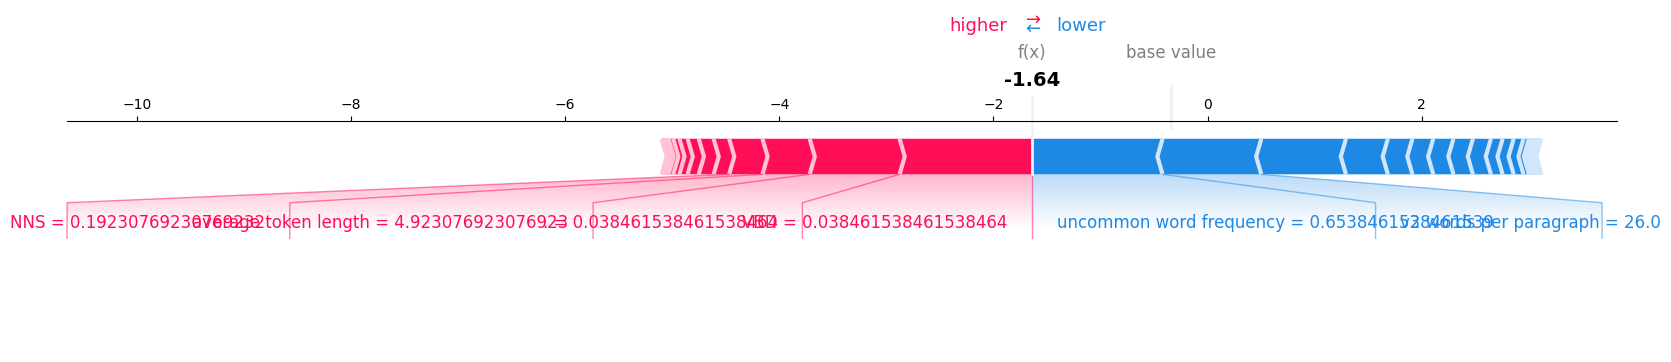

In [57]:
shap.force_plot(
    shap_expected_val,
    shap_vals[FIRST_DATA_INDEX],
    test_data.iloc[FIRST_DATA_INDEX],
)
shap.force_plot(
    shap_expected_val,
    shap_vals[FIRST_DATA_INDEX],
    test_data.iloc[FIRST_DATA_INDEX],
    matplotlib=True,
    show=False,
)
plt.savefig(
    PathUtil.SHAP_FIGURE_DIR.joinpath("inaugural", "shap_force_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()

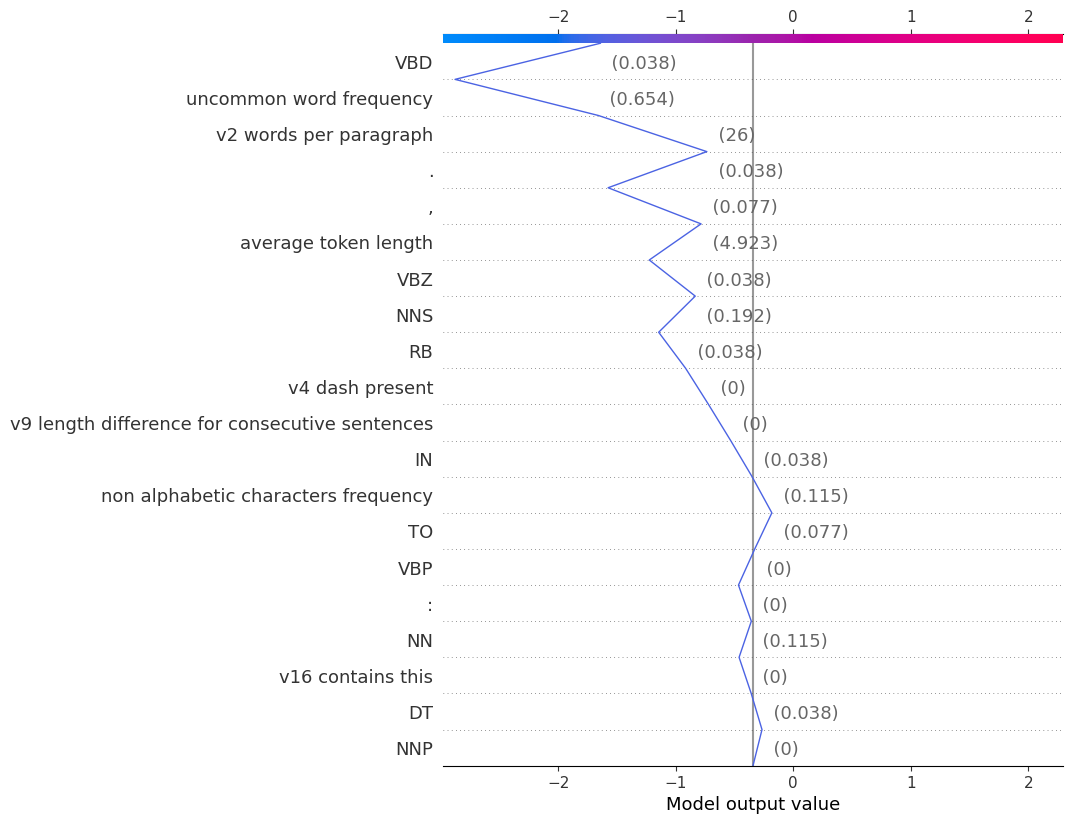

In [58]:
shap.decision_plot(
    shap_expected_val,
    shap_vals[FIRST_DATA_INDEX],
    test_data.iloc[FIRST_DATA_INDEX],
    show=False,
)
plt.savefig(
    PathUtil.SHAP_FIGURE_DIR.joinpath("inaugural", "shap_decision_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()

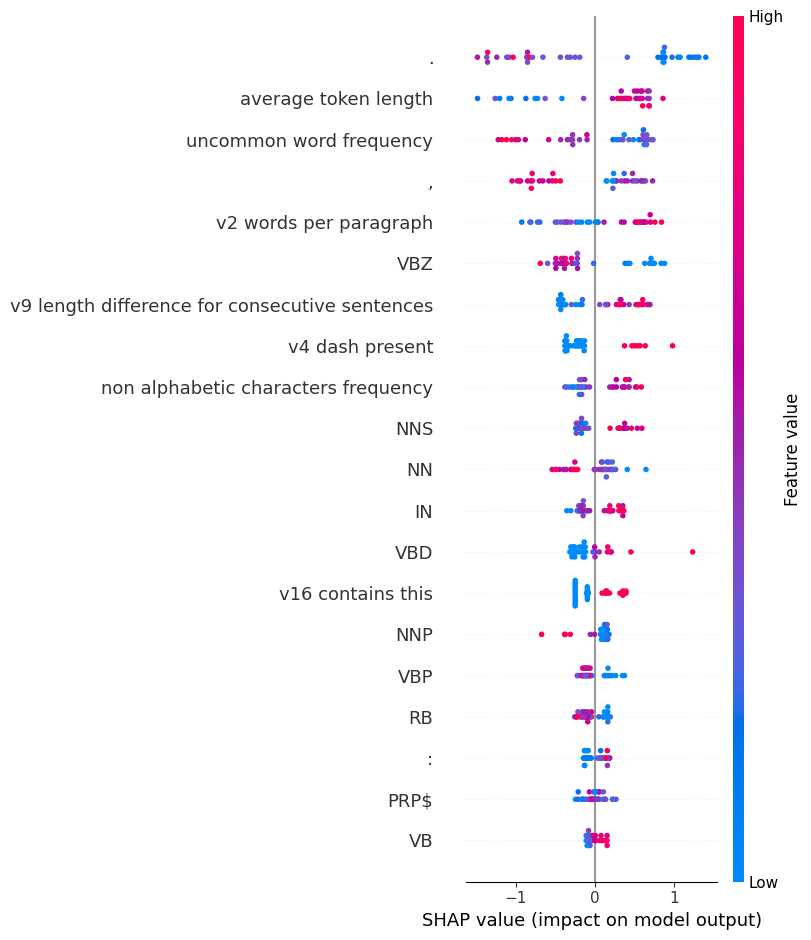

In [59]:
shap.summary_plot(
    shap_vals,
    test_data,
    show=False,
)
plt.savefig(
    PathUtil.SHAP_FIGURE_DIR.joinpath("inaugural", "shap_summary_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()

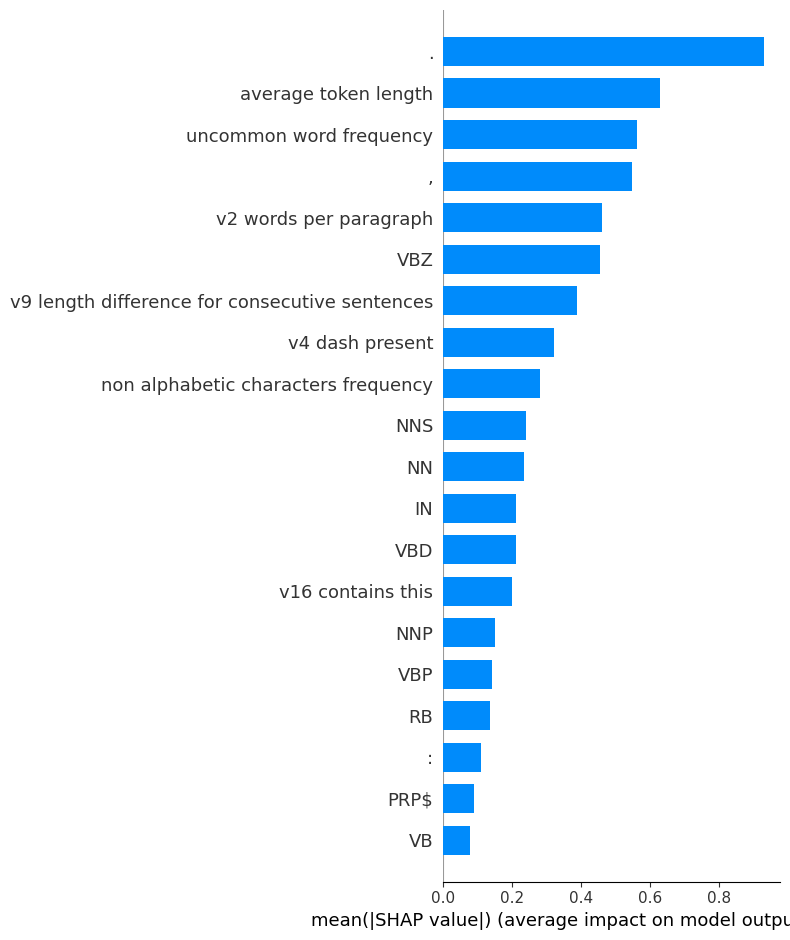

In [60]:
shap.summary_plot(
    shap_vals,
    test_data,
    plot_type="bar",
    show=False,
)
plt.savefig(
    PathUtil.SHAP_FIGURE_DIR.joinpath("inaugural", "shap_summary_plot_bar.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()